In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import utils, optimization, metrics, plot
import pickle

# Parameters

In [3]:
spix = 256
path = '/home/nati/data/andresro/dat/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [4]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [5]:
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])

In [6]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us plot 16 images

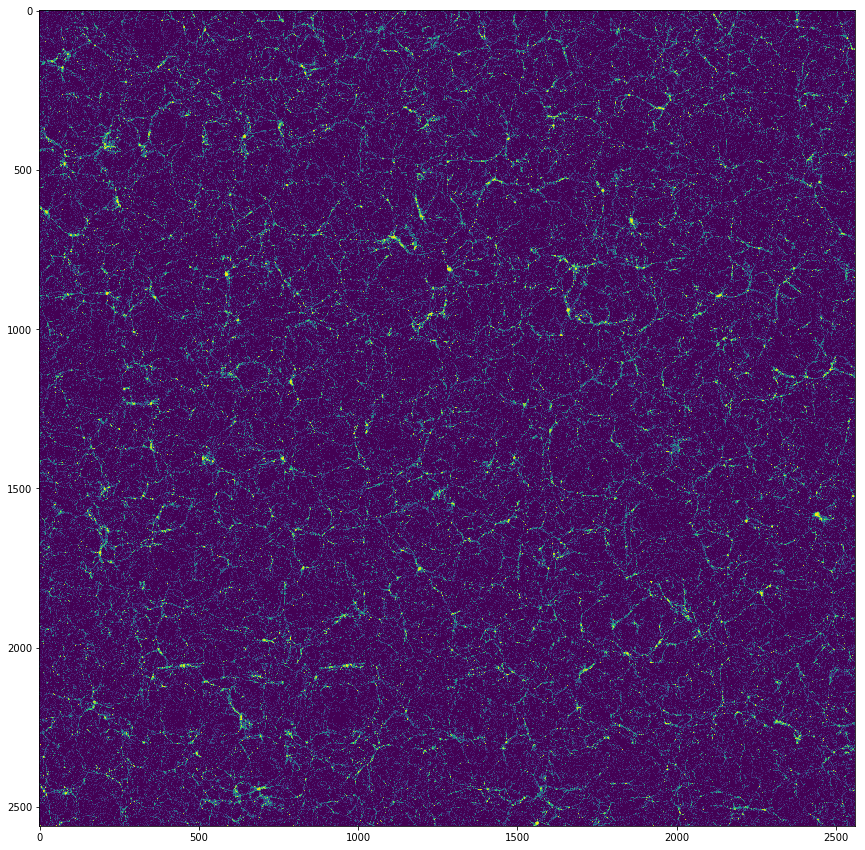

In [7]:
plt.figure(figsize=(15,15))
utils.draw_images(input_img,nx=10,ny=10,px=spix,py=spix)

This one looks strange (only for the 512x512)

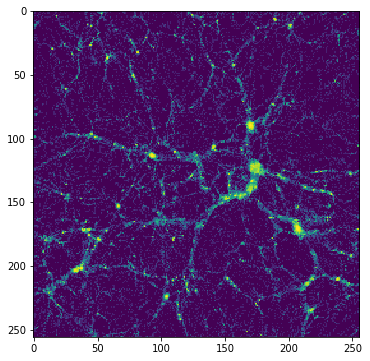

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(input_img[8,:,:])

It is a band of zeros...

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  4.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.],
       ..., 
       [ 2.,  0.,  1., ...,  2.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  1.,  1.]], dtype=float32)

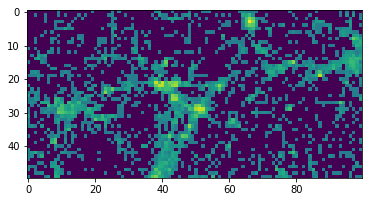

In [9]:
ori = np.fromfile(queue[8], dtype=float32).reshape([spix,spix])
plt.imshow(np.log(ori[150:200,:100]+0.01))
ori[150:200,:100]

Let us make small patches of 64 :-)

In [10]:
ns = 128
cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        k = j + i*cut 
        img_small[k*nsamples:(k+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

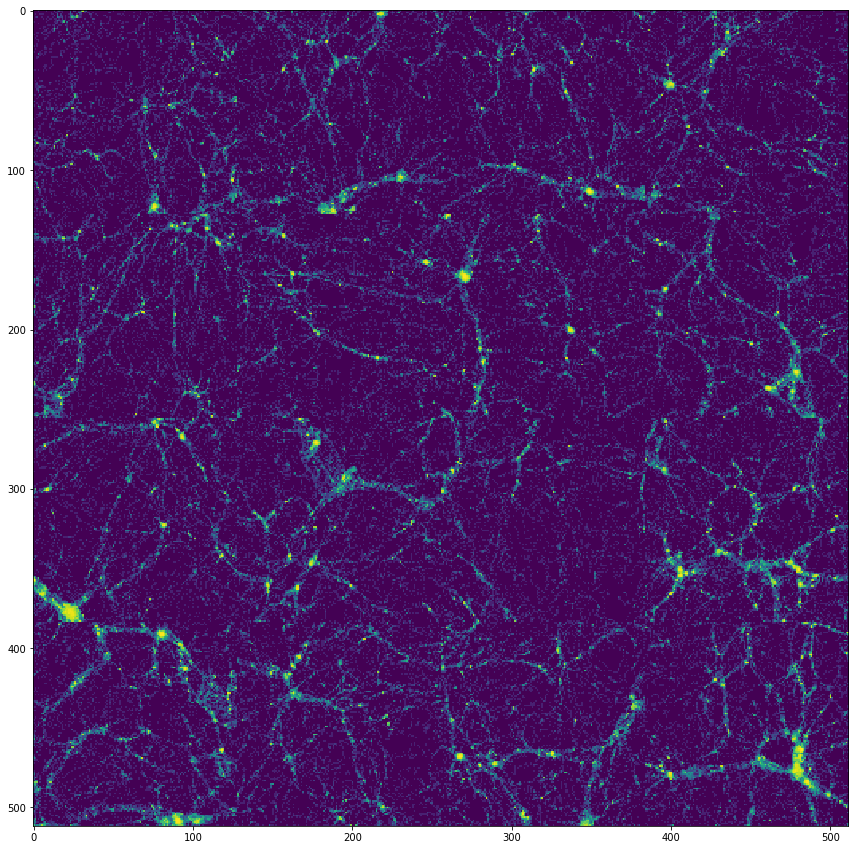

In [11]:
plt.figure(figsize=(15,15))
utils.draw_images(img_small,nx=4,ny=4,px=ns,py=ns)

# A) Train a small GAN

In [39]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)



params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 64]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5]]
params_discriminator['batch_norm'] = [True, True, True]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2]
params_generator['input_dim'] = 100
params_generator['nfilter'] = [16, 64, 1]
params_generator['shape'] = [[5, 5],[5, 5], [5, 5]]
params_generator['batch_norm'] = [True, True]
params_generator['full'] = [16*16*16]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['optimizer'] = 'adam' # rmsprop / adam
params_optimization['disc_learning_rate'] = 1e-5
params_optimization['gen_learning_rate'] = 1e-5
params_optimization['beta1'] = 0.99
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 100

params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization

params['image_size'] = [ns, ns]
params['sum_every'] = 200
params['viz_every'] = 200
params['save_every'] = 2000
global_path = '/home/nati/data/GAN/'+ current_time_str() +'_size_{}/'.format(ns)
params['summary_dir'] = global_path + 'summary/'
params['save_dir'] = global_path + 'checkpoints/'

params['clip_max_real'] = False
params['log_clip'] = 0.1
params['sigma_smooth'] = 1
params['k'] = k





In [40]:
from model import generator, discriminator
from gan import WGAN

class gan_model(object):
    def __init__(self, name='wgan'):
        self.name = name
    def generator(self, z, reuse):
        return generator(z, self.params['generator'], reuse=reuse)
    def discriminator(self, X, reuse):
        return discriminator(X, self.params['discriminator'], reuse=reuse)
    def __call__(self, params, z, X):
        self.params = params
        G_fake = self.generator(z, reuse=False)
        D_real = self.discriminator(X, reuse=False)
        D_fake = self.discriminator(G_fake, reuse=True)       
    
        return G_fake, D_real, D_fake

wgan_model = gan_model()
wgan_obj = WGAN(params, wgan_model)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 16, 16, 16)
     1 Deconv layer with 16 channels
         Batch norm
         Size of the variables: (?, 32, 32, 16)
     2 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 64, 64, 64)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 128, 128, 1)
    Non lienarity: tanh
     The output is of size (?, 128, 128, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 128, 128, 1)
     0 Conv layer with 16 channels
         Batch norm
         Size of the variables: (?, 64, 64, 16)
     1 Conv layer with 32 channels
         Batch norm
         Size of the variables: (?, 32, 32, 32)
     2 Conv layer with 64 channel

In [41]:
wgan_obj.train(img_small)

Epoch: [ 0] [  99/3750] Counter:100	( 0.4 min	65.95 examples/sec	0.243 sec/batch)	L_Disc:22.63623428	L_Gen:0.69746768
Epoch: [ 0] [ 599/3750] Counter:600	( 2.4 min	70.75 examples/sec	0.226 sec/batch)	L_Disc:-2.88929868	L_Gen:7.65686703
 [*] [Fake, Real] Min [1.187, 0.110],	Median [2.566,0.268],	Mean [2.640E+00,7.232E-01],	 Max [1.144E+01,1.542E+02],	 Var [3.967E-01,1.847E+01]
 [*] [Comp, Fake, Real] PeakDistance:[26.667, 0.103, 0.215]	CrossPS:[0.165, 0.003, 3.892]	PSD_Diff:150140.316
Epoch: [ 0] [ 699/3750] Counter:700	( 2.8 min	64.81 examples/sec	0.247 sec/batch)	L_Disc:-3.26027560	L_Gen:6.87255859
Epoch: [ 0] [ 799/3750] Counter:800	( 3.2 min	72.20 examples/sec	0.222 sec/batch)	L_Disc:-4.55207872	L_Gen:5.46476078
 [*] [Fake, Real] Min [0.843, 0.110],	Median [2.183,0.282],	Mean [2.269E+00,7.430E-01],	 Max [1.246E+01,1.701E+02],	 Var [4.293E-01,2.054E+01]
 [*] [Comp, Fake, Real] PeakDistance:[19.016, 0.356, 0.364]	CrossPS:[0.786, -0.074, -11.721]	PSD_Diff:171760.083
Epoch: [ 0] [ 899/3

 [*] [Fake, Real] Min [0.107, 0.109],	Median [0.230,0.264],	Mean [2.812E-01,6.624E-01],	 Max [5.203E+00,8.926E+01],	 Var [4.304E-02,6.522E+00]
 [*] [Comp, Fake, Real] PeakDistance:[18.199, 0.664, 0.241]	CrossPS:[-1.051, 0.709, -4.181]	PSD_Diff:49951.746
Epoch: [ 1] [ 149/3750] Counter:3900	(15.3 min	64.86 examples/sec	0.247 sec/batch)	L_Disc:-1.96364510	L_Gen:0.00472988
Epoch: [ 1] [ 249/3750] Counter:4000	(15.7 min	72.31 examples/sec	0.221 sec/batch)	L_Disc:-1.17579603	L_Gen:0.07825893
 [*] [Fake, Real] Min [0.104, 0.109],	Median [0.258,0.286],	Mean [3.763E-01,8.617E-01],	 Max [2.968E+01,2.987E+02],	 Var [5.369E-01,6.769E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.639, 0.128, 0.319]	CrossPS:[-0.391, 0.241, -8.286]	PSD_Diff:274714.751
Epoch: [ 1] [ 349/3750] Counter:4100	(16.1 min	63.22 examples/sec	0.253 sec/batch)	L_Disc:-1.27478039	L_Gen:0.01897389
Epoch: [ 1] [ 449/3750] Counter:4200	(16.5 min	72.23 examples/sec	0.222 sec/batch)	L_Disc:-1.30754673	L_Gen:0.42684695
 [*] [Fake, Real

Epoch: [ 1] [3449/3750] Counter:7200	(28.2 min	72.50 examples/sec	0.221 sec/batch)	L_Disc:-0.99599224	L_Gen:0.21875697
 [*] [Fake, Real] Min [0.101, 0.110],	Median [0.211,0.279],	Mean [4.843E-01,7.032E-01],	 Max [7.249E+01,1.203E+02],	 Var [5.601E+00,9.759E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.524, 0.158, 0.179]	CrossPS:[4.033, -5.190, -10.192]	PSD_Diff:9.242
 [*] New PSD Low achieved 9.242313 (was 642.082441)
Epoch: [ 1] [3549/3750] Counter:7300	(28.6 min	63.78 examples/sec	0.251 sec/batch)	L_Disc:-0.76422518	L_Gen:1.46507680
Epoch: [ 1] [3649/3750] Counter:7400	(29.0 min	72.44 examples/sec	0.221 sec/batch)	L_Disc:-0.71727318	L_Gen:2.95965528
 [*] [Fake, Real] Min [0.101, 0.107],	Median [0.222,0.248],	Mean [6.069E-01,5.692E-01],	 Max [1.164E+02,9.128E+01],	 Var [1.390E+01,5.386E+00]
 [*] [Comp, Fake, Real] PeakDistance:[1.332, 0.211, 0.236]	CrossPS:[-2.726, 2.769, -3.469]	PSD_Diff:29708.126
Epoch: [ 1] [3749/3750] Counter:7500	(29.4 min	64.98 examples/sec	0.246 sec/batch)	L_Dis

Epoch: [ 2] [2999/3750] Counter:10500	(41.1 min	65.00 examples/sec	0.246 sec/batch)	L_Disc:-1.69392455	L_Gen:11.33795547
Epoch: [ 2] [3099/3750] Counter:10600	(41.5 min	72.38 examples/sec	0.221 sec/batch)	L_Disc:-0.83584356	L_Gen:12.19606495
 [*] [Fake, Real] Min [0.101, 0.111],	Median [0.251,0.249],	Mean [6.897E-01,5.595E-01],	 Max [1.317E+02,8.038E+01],	 Var [1.389E+01,4.509E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.752, 0.196, 0.351]	CrossPS:[-5.089, 3.018, -2.337]	PSD_Diff:23603.115
Epoch: [ 2] [3199/3750] Counter:10700	(41.9 min	64.97 examples/sec	0.246 sec/batch)	L_Disc:-1.47260869	L_Gen:6.02179003
Epoch: [ 2] [3299/3750] Counter:10800	(42.3 min	72.31 examples/sec	0.221 sec/batch)	L_Disc:-1.00065684	L_Gen:7.50621223
 [*] [Fake, Real] Min [0.101, 0.111],	Median [0.243,0.271],	Mean [5.115E-01,6.761E-01],	 Max [5.069E+01,1.457E+02],	 Var [2.090E+00,1.377E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.187, 0.212, 0.131]	CrossPS:[-4.925, 2.099, 5.463]	PSD_Diff:74597.613
Epoch: [ 2] [

Epoch: [ 3] [2649/3750] Counter:13900	(54.4 min	65.08 examples/sec	0.246 sec/batch)	L_Disc:-1.51746321	L_Gen:9.40880871
Epoch: [ 3] [2749/3750] Counter:14000	(54.8 min	72.43 examples/sec	0.221 sec/batch)	L_Disc:-1.23484159	L_Gen:9.68873405
 [*] [Fake, Real] Min [0.101, 0.106],	Median [0.248,0.255],	Mean [7.690E-01,5.534E-01],	 Max [1.297E+02,7.893E+01],	 Var [1.985E+01,4.379E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.171, 0.182, 0.148]	CrossPS:[-4.403, -11.012, -3.066]	PSD_Diff:16541.419
Epoch: [ 3] [2849/3750] Counter:14100	(55.2 min	63.61 examples/sec	0.252 sec/batch)	L_Disc:-1.60944283	L_Gen:3.24736404
Epoch: [ 3] [2949/3750] Counter:14200	(55.5 min	72.32 examples/sec	0.221 sec/batch)	L_Disc:-1.38004458	L_Gen:3.65555215
 [*] [Fake, Real] Min [0.100, 0.108],	Median [0.218,0.273],	Mean [5.120E-01,8.187E-01],	 Max [6.432E+01,1.870E+02],	 Var [3.059E+00,2.551E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.225, 0.172, 0.270]	CrossPS:[-6.131, 8.827, -4.295]	PSD_Diff:63338.936
Epoch: [ 3] 

Epoch: [ 4] [2299/3750] Counter:17300	(67.7 min	65.09 examples/sec	0.246 sec/batch)	L_Disc:-1.13368404	L_Gen:3.77874684
Epoch: [ 4] [2399/3750] Counter:17400	(68.0 min	72.29 examples/sec	0.221 sec/batch)	L_Disc:-1.39578247	L_Gen:-0.49794614
 [*] [Fake, Real] Min [0.100, 0.109],	Median [0.249,0.278],	Mean [6.674E-01,7.939E-01],	 Max [7.146E+01,1.527E+02],	 Var [5.344E+00,2.224E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.213, 0.159, 0.197]	CrossPS:[6.965, -1.233, -2.762]	PSD_Diff:61286.400
Epoch: [ 4] [2499/3750] Counter:17500	(68.4 min	65.00 examples/sec	0.246 sec/batch)	L_Disc:-1.48380327	L_Gen:3.73718548
Epoch: [ 4] [2599/3750] Counter:17600	(68.8 min	72.36 examples/sec	0.221 sec/batch)	L_Disc:-1.30792928	L_Gen:6.52694368
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.248,0.292],	Mean [5.614E-01,7.010E-01],	 Max [5.804E+01,8.695E+01],	 Var [2.894E+00,5.470E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.348, 0.131, 0.264]	CrossPS:[-3.922, -1.267, -1.954]	PSD_Diff:25.826
Epoch: [ 4] [26

Epoch: [ 5] [1949/3750] Counter:20700	(81.0 min	64.53 examples/sec	0.248 sec/batch)	L_Disc:-1.85851586	L_Gen:11.01385498
Epoch: [ 5] [2049/3750] Counter:20800	(81.3 min	72.39 examples/sec	0.221 sec/batch)	L_Disc:-1.13510120	L_Gen:10.49292755
 [*] [Fake, Real] Min [0.100, 0.107],	Median [0.259,0.285],	Mean [6.309E-01,6.718E-01],	 Max [5.012E+01,9.165E+01],	 Var [3.123E+00,6.322E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.202, 0.247, 0.143]	CrossPS:[6.425, -1.702, -3.144]	PSD_Diff:1548.989
Epoch: [ 5] [2149/3750] Counter:20900	(81.7 min	64.86 examples/sec	0.247 sec/batch)	L_Disc:-1.37203109	L_Gen:1.55753255
Epoch: [ 5] [2249/3750] Counter:21000	(82.1 min	72.43 examples/sec	0.221 sec/batch)	L_Disc:-1.35119998	L_Gen:1.58120084
 [*] [Fake, Real] Min [0.100, 0.106],	Median [0.234,0.295],	Mean [4.589E-01,8.989E-01],	 Max [2.631E+01,2.044E+02],	 Var [8.836E-01,3.735E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.358, 0.358, 0.119]	CrossPS:[-0.777, 1.477, 0.298]	PSD_Diff:190228.473
Epoch: [ 5] [

Epoch: [ 6] [1599/3750] Counter:24100	(94.3 min	63.46 examples/sec	0.252 sec/batch)	L_Disc:-1.20506859	L_Gen:8.23359776
Epoch: [ 6] [1699/3750] Counter:24200	(94.6 min	72.32 examples/sec	0.221 sec/batch)	L_Disc:-1.00134456	L_Gen:2.38167453
 [*] [Fake, Real] Min [0.101, 0.107],	Median [0.262,0.283],	Mean [6.562E-01,8.571E-01],	 Max [6.391E+01,1.730E+02],	 Var [5.681E+00,2.378E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.237, 0.160, 0.165]	CrossPS:[-10.335, -4.277, -12.632]	PSD_Diff:587.003
Epoch: [ 6] [1799/3750] Counter:24300	(95.0 min	64.87 examples/sec	0.247 sec/batch)	L_Disc:-1.14076304	L_Gen:6.11564350
Epoch: [ 6] [1899/3750] Counter:24400	(95.4 min	72.44 examples/sec	0.221 sec/batch)	L_Disc:-1.60556328	L_Gen:11.67871189
 [*] [Fake, Real] Min [0.100, 0.107],	Median [0.213,0.293],	Mean [4.301E-01,6.580E-01],	 Max [3.144E+01,6.041E+01],	 Var [1.188E+00,3.618E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.336, 0.260, 0.133]	CrossPS:[0.943, 3.347, 4.011]	PSD_Diff:656.866
Epoch: [ 6] [199

Epoch: [ 7] [1249/3750] Counter:27500	(107.5 min	65.08 examples/sec	0.246 sec/batch)	L_Disc:-1.08352530	L_Gen:5.14336872
Epoch: [ 7] [1349/3750] Counter:27600	(107.9 min	72.38 examples/sec	0.221 sec/batch)	L_Disc:-1.05051804	L_Gen:4.45578861
 [*] [Fake, Real] Min [0.100, 0.108],	Median [0.228,0.276],	Mean [4.766E-01,7.004E-01],	 Max [2.887E+01,1.189E+02],	 Var [9.977E-01,1.061E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.246, 0.122, 0.214]	CrossPS:[-4.116, 3.987, -5.602]	PSD_Diff:23028.855
Epoch: [ 7] [1449/3750] Counter:27700	(108.3 min	64.89 examples/sec	0.247 sec/batch)	L_Disc:-1.06146467	L_Gen:9.71833515
Epoch: [ 7] [1549/3750] Counter:27800	(108.7 min	72.35 examples/sec	0.221 sec/batch)	L_Disc:-1.24420679	L_Gen:11.27644730
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.247,0.271],	Mean [6.163E-01,7.049E-01],	 Max [7.388E+01,1.650E+02],	 Var [4.271E+00,1.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.228, 0.222, 0.182]	CrossPS:[-4.214, -2.332, -4.990]	PSD_Diff:70230.341
Epoch: [

Epoch: [ 8] [ 899/3750] Counter:30900	(120.8 min	64.84 examples/sec	0.247 sec/batch)	L_Disc:-1.12743962	L_Gen:9.86844826
Epoch: [ 8] [ 999/3750] Counter:31000	(121.2 min	72.31 examples/sec	0.221 sec/batch)	L_Disc:-0.98112494	L_Gen:10.05851555
 [*] [Fake, Real] Min [0.100, 0.107],	Median [0.239,0.247],	Mean [5.327E-01,5.679E-01],	 Max [9.228E+01,1.338E+02],	 Var [1.571E+01,1.266E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.284, 0.151, 0.333]	CrossPS:[4.253, -2.696, 2.581]	PSD_Diff:49433.129
Epoch: [ 8] [1099/3750] Counter:31100	(121.6 min	64.63 examples/sec	0.248 sec/batch)	L_Disc:-1.01160038	L_Gen:8.54304886
Epoch: [ 8] [1199/3750] Counter:31200	(121.9 min	72.30 examples/sec	0.221 sec/batch)	L_Disc:-0.98431754	L_Gen:9.51643848
 [*] [Fake, Real] Min [0.100, 0.109],	Median [0.232,0.260],	Mean [5.027E-01,7.950E-01],	 Max [4.508E+01,3.035E+02],	 Var [1.882E+00,1.104E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.283, 0.062, 0.392]	CrossPS:[-1.938, 9.491, -17.362]	PSD_Diff:376479.906
Epoch: [

Epoch: [ 9] [ 549/3750] Counter:34300	(134.1 min	64.71 examples/sec	0.247 sec/batch)	L_Disc:-1.27396739	L_Gen:13.89696312
Epoch: [ 9] [ 649/3750] Counter:34400	(134.4 min	72.45 examples/sec	0.221 sec/batch)	L_Disc:-0.92913651	L_Gen:12.50969887
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.292,0.281],	Mean [8.258E-01,7.519E-01],	 Max [9.808E+01,1.578E+02],	 Var [1.671E+01,1.583E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.236, 0.397, 0.076]	CrossPS:[-8.616, -9.148, 8.967]	PSD_Diff:3573.974
Epoch: [ 9] [ 749/3750] Counter:34500	(134.9 min	64.83 examples/sec	0.247 sec/batch)	L_Disc:-1.23402297	L_Gen:5.24175930
Epoch: [ 9] [ 849/3750] Counter:34600	(135.2 min	72.49 examples/sec	0.221 sec/batch)	L_Disc:-0.94613051	L_Gen:4.60447598
 [*] [Fake, Real] Min [0.100, 0.107],	Median [0.233,0.266],	Mean [4.831E-01,6.451E-01],	 Max [4.930E+01,1.151E+02],	 Var [2.002E+00,9.123E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.268, 0.445, 0.091]	CrossPS:[0.912, -3.832, -5.878]	PSD_Diff:35129.092
Epoch: [ 

Epoch: [10] [ 199/3750] Counter:37700	(147.3 min	64.92 examples/sec	0.246 sec/batch)	L_Disc:-1.14115179	L_Gen:6.51244545
Epoch: [10] [ 299/3750] Counter:37800	(147.7 min	72.46 examples/sec	0.221 sec/batch)	L_Disc:-1.02632809	L_Gen:10.73034859
 [*] [Fake, Real] Min [0.100, 0.110],	Median [0.225,0.278],	Mean [4.768E-01,7.954E-01],	 Max [3.583E+01,1.914E+02],	 Var [1.469E+00,2.429E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.195, 0.148, 0.135]	CrossPS:[3.003, -5.968, 3.226]	PSD_Diff:81080.538
Epoch: [10] [ 399/3750] Counter:37900	(148.1 min	64.67 examples/sec	0.247 sec/batch)	L_Disc:-1.04916012	L_Gen:9.68880844
Epoch: [10] [ 499/3750] Counter:38000	(148.5 min	72.51 examples/sec	0.221 sec/batch)	L_Disc:-1.06433666	L_Gen:6.23077536
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.268,0.270],	Mean [6.904E-01,7.257E-01],	 Max [4.982E+01,1.827E+02],	 Var [3.957E+00,3.622E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.231, 0.200, 0.238]	CrossPS:[-1.554, -2.103, -8.965]	PSD_Diff:51381.209
Epoch: [1

Epoch: [10] [3599/3750] Counter:41100	(160.6 min	65.29 examples/sec	0.245 sec/batch)	L_Disc:-1.01413310	L_Gen:7.69498587
Epoch: [10] [3699/3750] Counter:41200	(161.0 min	72.44 examples/sec	0.221 sec/batch)	L_Disc:-0.83973473	L_Gen:7.00311279
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.256,0.262],	Mean [5.865E-01,7.498E-01],	 Max [4.250E+01,3.204E+02],	 Var [2.897E+00,5.769E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.301, 0.233, 0.186]	CrossPS:[3.992, 2.012, 7.974]	PSD_Diff:384365.902
Epoch: [11] [  49/3750] Counter:41300	(161.4 min	64.94 examples/sec	0.246 sec/batch)	L_Disc:-1.09743011	L_Gen:2.73182821
Epoch: [11] [ 149/3750] Counter:41400	(161.7 min	72.52 examples/sec	0.221 sec/batch)	L_Disc:-1.07027006	L_Gen:3.52570772
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.229,0.289],	Mean [4.944E-01,7.640E-01],	 Max [3.636E+01,1.394E+02],	 Var [1.508E+00,1.829E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.488, 0.100, 0.462]	CrossPS:[-0.609, 0.911, 1.748]	PSD_Diff:21470.693
Epoch: [11] 

Epoch: [11] [3249/3750] Counter:44500	(173.9 min	64.54 examples/sec	0.248 sec/batch)	L_Disc:-1.00232089	L_Gen:3.33458328
Epoch: [11] [3349/3750] Counter:44600	(174.2 min	72.58 examples/sec	0.220 sec/batch)	L_Disc:-1.15707111	L_Gen:5.58853006
 [*] [Fake, Real] Min [0.100, 0.106],	Median [0.207,0.262],	Mean [4.780E-01,5.984E-01],	 Max [4.012E+01,6.793E+01],	 Var [3.439E+00,4.493E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.176, 0.197, 0.141]	CrossPS:[-1.833, 3.892, -4.406]	PSD_Diff:4128.707
Epoch: [11] [3449/3750] Counter:44700	(174.6 min	64.94 examples/sec	0.246 sec/batch)	L_Disc:-1.28928828	L_Gen:8.78290176
Epoch: [11] [3549/3750] Counter:44800	(175.0 min	72.45 examples/sec	0.221 sec/batch)	L_Disc:-0.97414738	L_Gen:6.93059063
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.266,0.263],	Mean [7.098E-01,6.255E-01],	 Max [8.052E+01,1.217E+02],	 Var [9.811E+00,9.085E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.224, 0.207, 0.194]	CrossPS:[-2.551, 0.962, -0.256]	PSD_Diff:9999.878
Epoch: [11] 

Epoch: [12] [2899/3750] Counter:47900	(187.1 min	64.94 examples/sec	0.246 sec/batch)	L_Disc:-0.83606678	L_Gen:3.51231432
Epoch: [12] [2999/3750] Counter:48000	(187.5 min	72.50 examples/sec	0.221 sec/batch)	L_Disc:-1.02028358	L_Gen:6.04484367
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.239,0.271],	Mean [4.556E-01,7.255E-01],	 Max [2.387E+01,1.471E+02],	 Var [8.897E-01,1.360E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.638, 0.155, 0.230]	CrossPS:[-0.541, 0.733, 2.633]	PSD_Diff:40845.151
Epoch: [12] [3099/3750] Counter:48100	(187.9 min	63.47 examples/sec	0.252 sec/batch)	L_Disc:-0.88835108	L_Gen:5.57522774
Epoch: [12] [3199/3750] Counter:48200	(188.3 min	72.40 examples/sec	0.221 sec/batch)	L_Disc:-1.05358160	L_Gen:3.14361262
 [*] [Fake, Real] Min [0.101, 0.110],	Median [0.253,0.284],	Mean [5.581E-01,6.846E-01],	 Max [3.752E+01,1.028E+02],	 Var [1.962E+00,6.727E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.365, 0.154, 0.120]	CrossPS:[-2.720, -4.034, 7.760]	PSD_Diff:7295.493
Epoch: [12] 

 [*] [Fake, Real] Min [0.100, 0.108],	Median [0.279,0.299],	Mean [7.129E-01,7.268E-01],	 Max [5.320E+01,1.305E+02],	 Var [3.821E+00,1.207E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.114, 0.148, 0.073]	CrossPS:[7.457, -3.000, 1.848]	PSD_Diff:5310.307
Epoch: [13] [2549/3750] Counter:51300	(200.4 min	65.08 examples/sec	0.246 sec/batch)	L_Disc:-0.88223106	L_Gen:0.69068730
Epoch: [13] [2649/3750] Counter:51400	(200.8 min	72.52 examples/sec	0.221 sec/batch)	L_Disc:-1.25326586	L_Gen:4.52654362
 [*] [Fake, Real] Min [0.101, 0.107],	Median [0.229,0.269],	Mean [4.414E-01,7.655E-01],	 Max [3.134E+01,1.932E+02],	 Var [8.353E-01,2.762E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.351, 0.154, 0.117]	CrossPS:[-5.701, -1.145, -4.413]	PSD_Diff:114012.800
Epoch: [13] [2749/3750] Counter:51500	(201.2 min	65.03 examples/sec	0.246 sec/batch)	L_Disc:-0.81093568	L_Gen:4.82174158
Epoch: [13] [2849/3750] Counter:51600	(201.5 min	72.46 examples/sec	0.221 sec/batch)	L_Disc:-1.16489029	L_Gen:0.81792581
 [*] [Fake

Epoch: [14] [2099/3750] Counter:54600	(213.2 min	72.54 examples/sec	0.221 sec/batch)	L_Disc:-0.78345758	L_Gen:-0.21010052
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.284,0.270],	Mean [6.389E-01,7.690E-01],	 Max [4.422E+01,1.801E+02],	 Var [2.705E+00,1.891E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.518, 0.442, 0.196]	CrossPS:[7.077, -1.860, -0.841]	PSD_Diff:67684.698
Epoch: [14] [2199/3750] Counter:54700	(213.7 min	64.90 examples/sec	0.247 sec/batch)	L_Disc:-1.16217589	L_Gen:2.08652639
Epoch: [14] [2299/3750] Counter:54800	(214.0 min	72.53 examples/sec	0.221 sec/batch)	L_Disc:-0.88437867	L_Gen:4.58683443
 [*] [Fake, Real] Min [0.101, 0.107],	Median [0.238,0.274],	Mean [4.741E-01,5.788E-01],	 Max [3.297E+01,5.647E+01],	 Var [1.165E+00,3.131E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.185, 0.197, 0.128]	CrossPS:[3.121, 1.686, 4.519]	PSD_Diff:448.337
Epoch: [14] [2399/3750] Counter:54900	(214.4 min	64.92 examples/sec	0.246 sec/batch)	L_Disc:-0.97190624	L_Gen:1.80257452
Epoch: [14] [

Epoch: [15] [1649/3750] Counter:57900	(226.1 min	65.04 examples/sec	0.246 sec/batch)	L_Disc:-1.00081325	L_Gen:1.40901852
Epoch: [15] [1749/3750] Counter:58000	(226.5 min	72.50 examples/sec	0.221 sec/batch)	L_Disc:-1.12749660	L_Gen:3.14219666
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.233,0.271],	Mean [4.436E-01,6.311E-01],	 Max [2.538E+01,1.049E+02],	 Var [8.346E-01,7.089E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.305, 0.258, 0.237]	CrossPS:[1.792, 0.966, 8.180]	PSD_Diff:12448.873
Epoch: [15] [1849/3750] Counter:58100	(226.9 min	63.29 examples/sec	0.253 sec/batch)	L_Disc:-0.86162877	L_Gen:3.68999410
Epoch: [15] [1949/3750] Counter:58200	(227.3 min	72.41 examples/sec	0.221 sec/batch)	L_Disc:-1.00248480	L_Gen:2.26602936
 [*] [Fake, Real] Min [0.101, 0.107],	Median [0.274,0.288],	Mean [6.408E-01,6.945E-01],	 Max [5.946E+01,1.007E+02],	 Var [3.747E+00,6.994E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.328, 0.364, 0.139]	CrossPS:[4.224, -6.793, 0.711]	PSD_Diff:576.300
Epoch: [15] [20

Epoch: [16] [1299/3750] Counter:61300	(239.4 min	65.21 examples/sec	0.245 sec/batch)	L_Disc:-1.31896162	L_Gen:5.01529598
Epoch: [16] [1399/3750] Counter:61400	(239.7 min	72.47 examples/sec	0.221 sec/batch)	L_Disc:-0.98134202	L_Gen:4.61718655
 [*] [Fake, Real] Min [0.101, 0.111],	Median [0.245,0.303],	Mean [4.933E-01,1.056E+00],	 Max [3.149E+01,3.899E+02],	 Var [1.501E+00,8.285E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.247, 0.197, 0.281]	CrossPS:[-3.014, -1.839, -9.977]	PSD_Diff:485109.252
Epoch: [16] [1499/3750] Counter:61500	(240.2 min	64.88 examples/sec	0.247 sec/batch)	L_Disc:-0.83276045	L_Gen:1.11163294
Epoch: [16] [1599/3750] Counter:61600	(240.5 min	72.52 examples/sec	0.221 sec/batch)	L_Disc:-1.05142343	L_Gen:1.33487856
 [*] [Fake, Real] Min [0.100, 0.110],	Median [0.236,0.268],	Mean [4.297E-01,5.715E-01],	 Max [2.118E+01,6.803E+01],	 Var [6.126E-01,4.225E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.250, 0.082, 0.138]	CrossPS:[-1.840, -0.961, -2.869]	PSD_Diff:9056.459
Epoch: [

Epoch: [17] [ 949/3750] Counter:64700	(252.6 min	64.89 examples/sec	0.247 sec/batch)	L_Disc:-1.03980315	L_Gen:4.07176304
Epoch: [17] [1049/3750] Counter:64800	(253.0 min	72.35 examples/sec	0.221 sec/batch)	L_Disc:-0.84514821	L_Gen:4.26950645
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.276,0.286],	Mean [6.078E-01,7.709E-01],	 Max [3.902E+01,1.420E+02],	 Var [2.171E+00,1.477E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.144, 0.103, 0.117]	CrossPS:[4.345, -2.386, -14.288]	PSD_Diff:48040.950
Epoch: [17] [1149/3750] Counter:64900	(253.4 min	64.85 examples/sec	0.247 sec/batch)	L_Disc:-1.04317200	L_Gen:1.68759596
Epoch: [17] [1249/3750] Counter:65000	(253.8 min	72.51 examples/sec	0.221 sec/batch)	L_Disc:-1.13342428	L_Gen:3.16987157
 [*] [Fake, Real] Min [0.101, 0.110],	Median [0.213,0.280],	Mean [3.943E-01,6.986E-01],	 Max [2.026E+01,1.406E+02],	 Var [7.134E-01,1.305E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.478, 0.250, 0.210]	CrossPS:[6.021, -3.241, -3.404]	PSD_Diff:25191.005
Epoch: [1

Epoch: [18] [ 599/3750] Counter:68100	(265.9 min	63.57 examples/sec	0.252 sec/batch)	L_Disc:-0.87958574	L_Gen:0.40329772
Epoch: [18] [ 699/3750] Counter:68200	(266.3 min	72.54 examples/sec	0.221 sec/batch)	L_Disc:-1.05196488	L_Gen:3.20096159
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.223,0.274],	Mean [4.076E-01,7.673E-01],	 Max [2.303E+01,1.677E+02],	 Var [7.061E-01,2.303E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.482, 0.342, 0.108]	CrossPS:[0.124, -0.212, -0.174]	PSD_Diff:71297.267
Epoch: [18] [ 799/3750] Counter:68300	(266.7 min	64.73 examples/sec	0.247 sec/batch)	L_Disc:-1.21711159	L_Gen:5.47105360
Epoch: [18] [ 899/3750] Counter:68400	(267.0 min	72.47 examples/sec	0.221 sec/batch)	L_Disc:-0.95671302	L_Gen:4.54197979
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.275,0.268],	Mean [5.875E-01,5.728E-01],	 Max [2.939E+01,8.682E+01],	 Var [1.444E+00,4.867E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.253, 0.128, 0.195]	CrossPS:[0.810, 0.407, 2.368]	PSD_Diff:5720.252
Epoch: [18] [

Epoch: [19] [ 249/3750] Counter:71500	(279.1 min	64.81 examples/sec	0.247 sec/batch)	L_Disc:-0.97274333	L_Gen:4.11210442
Epoch: [19] [ 349/3750] Counter:71600	(279.5 min	72.49 examples/sec	0.221 sec/batch)	L_Disc:-0.89907652	L_Gen:2.87051535
 [*] [Fake, Real] Min [0.100, 0.109],	Median [0.262,0.281],	Mean [5.046E-01,8.033E-01],	 Max [3.475E+01,1.202E+02],	 Var [1.544E+00,1.651E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.400, 0.109, 0.163]	CrossPS:[1.115, -0.717, -4.474]	PSD_Diff:40038.144
Epoch: [19] [ 449/3750] Counter:71700	(279.9 min	64.86 examples/sec	0.247 sec/batch)	L_Disc:-0.92182493	L_Gen:2.02514267
Epoch: [19] [ 549/3750] Counter:71800	(280.3 min	72.53 examples/sec	0.221 sec/batch)	L_Disc:-0.81673908	L_Gen:4.08954811
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.232,0.271],	Mean [4.427E-01,6.543E-01],	 Max [2.340E+01,9.833E+01],	 Var [9.800E-01,8.097E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.318, 0.228, 0.237]	CrossPS:[-4.326, -4.593, -3.678]	PSD_Diff:17270.672
Epoch: [1

Epoch: [19] [3649/3750] Counter:74900	(292.4 min	64.69 examples/sec	0.247 sec/batch)	L_Disc:-0.68829089	L_Gen:6.18313837
Epoch: [19] [3749/3750] Counter:75000	(292.8 min	72.52 examples/sec	0.221 sec/batch)	L_Disc:-0.72548366	L_Gen:3.42016816
 [*] [Fake, Real] Min [0.101, 0.107],	Median [0.264,0.264],	Mean [5.764E-01,6.690E-01],	 Max [4.306E+01,1.174E+02],	 Var [2.247E+00,1.095E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.193, 0.132, 0.181]	CrossPS:[0.365, 2.945, -3.647]	PSD_Diff:24533.689
Epoch: [20] [  99/3750] Counter:75100	(293.2 min	64.99 examples/sec	0.246 sec/batch)	L_Disc:-0.88338673	L_Gen:2.09536982
Epoch: [20] [ 199/3750] Counter:75200	(293.5 min	72.44 examples/sec	0.221 sec/batch)	L_Disc:-1.04189706	L_Gen:3.29076123
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.229,0.277],	Mean [4.333E-01,6.666E-01],	 Max [2.930E+01,1.368E+02],	 Var [1.152E+00,8.938E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.272, 0.222, 0.129]	CrossPS:[-1.963, -3.361, -2.078]	PSD_Diff:11377.914
Epoch: [20

Epoch: [20] [3299/3750] Counter:78300	(305.6 min	65.38 examples/sec	0.245 sec/batch)	L_Disc:-0.79277450	L_Gen:4.30160809
Epoch: [20] [3399/3750] Counter:78400	(306.0 min	72.44 examples/sec	0.221 sec/batch)	L_Disc:-0.80130428	L_Gen:4.30597782
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.248,0.274],	Mean [4.742E-01,7.201E-01],	 Max [2.592E+01,1.877E+02],	 Var [1.018E+00,2.170E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.239, 0.154, 0.150]	CrossPS:[1.925, -1.488, -4.323]	PSD_Diff:93525.303
Epoch: [20] [3499/3750] Counter:78500	(306.4 min	64.75 examples/sec	0.247 sec/batch)	L_Disc:-0.81186950	L_Gen:3.31980753
Epoch: [20] [3599/3750] Counter:78600	(306.8 min	72.54 examples/sec	0.221 sec/batch)	L_Disc:-0.85203135	L_Gen:3.70176244
 [*] [Fake, Real] Min [0.100, 0.108],	Median [0.242,0.261],	Mean [4.871E-01,6.313E-01],	 Max [2.755E+01,1.185E+02],	 Var [1.248E+00,9.521E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.307, 0.217, 0.188]	CrossPS:[0.373, 1.387, 1.706]	PSD_Diff:34738.940
Epoch: [20] 

Epoch: [21] [2949/3750] Counter:81700	(318.9 min	64.90 examples/sec	0.247 sec/batch)	L_Disc:-0.93960804	L_Gen:3.69313049
Epoch: [21] [3049/3750] Counter:81800	(319.3 min	72.46 examples/sec	0.221 sec/batch)	L_Disc:-0.95425481	L_Gen:2.59376740
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.259,0.253],	Mean [5.560E-01,5.360E-01],	 Max [3.269E+01,5.892E+01],	 Var [1.568E+00,2.666E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.167, 0.147, 0.163]	CrossPS:[-1.171, 2.145, 5.629]	PSD_Diff:5.577
Epoch: [21] [3149/3750] Counter:81900	(319.7 min	65.03 examples/sec	0.246 sec/batch)	L_Disc:-1.08714056	L_Gen:3.02673292
Epoch: [21] [3249/3750] Counter:82000	(320.0 min	72.46 examples/sec	0.221 sec/batch)	L_Disc:-0.74588805	L_Gen:4.57333088
 [*] [Fake, Real] Min [0.101, 0.110],	Median [0.224,0.253],	Mean [4.160E-01,6.241E-01],	 Max [2.301E+01,1.530E+02],	 Var [6.815E-01,1.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.142, 0.089, 0.106]	CrossPS:[3.351, 2.796, -2.935]	PSD_Diff:131361.896
Epoch: [21] [33

Epoch: [22] [2599/3750] Counter:85100	(332.1 min	64.79 examples/sec	0.247 sec/batch)	L_Disc:-0.82665825	L_Gen:3.97222424
Epoch: [22] [2699/3750] Counter:85200	(332.5 min	72.45 examples/sec	0.221 sec/batch)	L_Disc:-0.80302936	L_Gen:2.59012580
 [*] [Fake, Real] Min [0.101, 0.107],	Median [0.252,0.263],	Mean [5.327E-01,6.262E-01],	 Max [4.377E+01,1.101E+02],	 Var [2.360E+00,1.133E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.267, 0.264, 0.203]	CrossPS:[-0.762, -10.402, 9.707]	PSD_Diff:5065.673
Epoch: [22] [2799/3750] Counter:85300	(332.9 min	64.98 examples/sec	0.246 sec/batch)	L_Disc:-0.92984509	L_Gen:3.57935739
Epoch: [22] [2899/3750] Counter:85400	(333.3 min	72.49 examples/sec	0.221 sec/batch)	L_Disc:-0.83221877	L_Gen:3.91388273
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.248,0.250],	Mean [4.804E-01,5.039E-01],	 Max [2.178E+01,5.908E+01],	 Var [8.736E-01,2.614E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.276, 0.331, 0.179]	CrossPS:[-0.196, -0.673, 0.089]	PSD_Diff:917.936
Epoch: [22] 

Epoch: [23] [2249/3750] Counter:88500	(345.4 min	64.80 examples/sec	0.247 sec/batch)	L_Disc:-1.12890387	L_Gen:2.85374665
Epoch: [23] [2349/3750] Counter:88600	(345.8 min	72.45 examples/sec	0.221 sec/batch)	L_Disc:-0.91239864	L_Gen:2.91412425
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.269,0.275],	Mean [5.865E-01,8.213E-01],	 Max [3.223E+01,1.818E+02],	 Var [1.730E+00,3.144E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.246, 0.289, 0.202]	CrossPS:[-1.004, 0.719, -6.489]	PSD_Diff:141947.544
Epoch: [23] [2449/3750] Counter:88700	(346.2 min	64.90 examples/sec	0.247 sec/batch)	L_Disc:-0.75445473	L_Gen:1.27479792
Epoch: [23] [2549/3750] Counter:88800	(346.5 min	72.44 examples/sec	0.221 sec/batch)	L_Disc:-0.79573566	L_Gen:1.39048862
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.236,0.260],	Mean [4.655E-01,6.323E-01],	 Max [2.186E+01,1.769E+02],	 Var [9.363E-01,3.179E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.266, 0.327, 0.184]	CrossPS:[0.164, -1.281, 8.014]	PSD_Diff:91819.318
Epoch: [23

Epoch: [24] [1899/3750] Counter:91900	(358.6 min	64.89 examples/sec	0.247 sec/batch)	L_Disc:-0.94683975	L_Gen:1.35954988
Epoch: [24] [1999/3750] Counter:92000	(359.0 min	72.50 examples/sec	0.221 sec/batch)	L_Disc:-0.90848213	L_Gen:1.90452695
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.250,0.303],	Mean [5.728E-01,7.288E-01],	 Max [4.759E+01,8.862E+01],	 Var [3.904E+00,5.775E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.700, 0.315, 0.298]	CrossPS:[-1.328, -14.564, 2.723]	PSD_Diff:3798.718
Epoch: [24] [2099/3750] Counter:92100	(359.4 min	63.18 examples/sec	0.253 sec/batch)	L_Disc:-0.90667498	L_Gen:1.30059040
Epoch: [24] [2199/3750] Counter:92200	(359.8 min	72.59 examples/sec	0.220 sec/batch)	L_Disc:-0.83967376	L_Gen:1.07455909
 [*] [Fake, Real] Min [0.101, 0.110],	Median [0.235,0.288],	Mean [5.125E-01,6.251E-01],	 Max [4.805E+01,7.565E+01],	 Var [2.500E+00,4.331E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.220, 0.170, 0.163]	CrossPS:[-3.379, -4.335, -4.928]	PSD_Diff:169.691
Epoch: [24]

Epoch: [25] [1549/3750] Counter:95300	(371.9 min	64.94 examples/sec	0.246 sec/batch)	L_Disc:-0.89018345	L_Gen:1.15494823
Epoch: [25] [1649/3750] Counter:95400	(372.3 min	72.53 examples/sec	0.221 sec/batch)	L_Disc:-0.85572827	L_Gen:1.13627601
 [*] [Fake, Real] Min [0.101, 0.107],	Median [0.259,0.248],	Mean [5.192E-01,5.441E-01],	 Max [4.054E+01,8.376E+01],	 Var [1.960E+00,5.092E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.329, 0.463, 0.185]	CrossPS:[-1.212, 8.098, -10.037]	PSD_Diff:7955.935
Epoch: [25] [1749/3750] Counter:95500	(372.7 min	65.00 examples/sec	0.246 sec/batch)	L_Disc:-0.92383337	L_Gen:0.78758889
Epoch: [25] [1849/3750] Counter:95600	(373.0 min	72.61 examples/sec	0.220 sec/batch)	L_Disc:-0.81252718	L_Gen:1.36801612
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.225,0.265],	Mean [5.149E-01,5.813E-01],	 Max [5.042E+01,5.949E+01],	 Var [4.612E+00,3.583E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.436, 0.349, 0.159]	CrossPS:[-5.138, -13.899, 1.235]	PSD_Diff:15083.663
Epoch: [2

Epoch: [26] [1199/3750] Counter:98700	(385.1 min	64.85 examples/sec	0.247 sec/batch)	L_Disc:-0.76112139	L_Gen:-0.52788782
Epoch: [26] [1299/3750] Counter:98800	(385.5 min	72.55 examples/sec	0.221 sec/batch)	L_Disc:-1.05264580	L_Gen:1.04467833
 [*] [Fake, Real] Min [0.101, 0.110],	Median [0.237,0.287],	Mean [4.290E-01,7.879E-01],	 Max [2.982E+01,1.617E+02],	 Var [1.204E+00,2.860E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.829, 0.266, 0.307]	CrossPS:[4.198, -1.935, -7.569]	PSD_Diff:38171.938
Epoch: [26] [1399/3750] Counter:98900	(385.9 min	64.89 examples/sec	0.247 sec/batch)	L_Disc:-0.70376855	L_Gen:0.95951569
Epoch: [26] [1499/3750] Counter:99000	(386.3 min	72.53 examples/sec	0.221 sec/batch)	L_Disc:-0.49851581	L_Gen:-0.55467266
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.245,0.277],	Mean [5.188E-01,7.716E-01],	 Max [4.533E+01,1.242E+02],	 Var [2.207E+00,1.522E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.361, 0.167, 0.156]	CrossPS:[-4.022, 0.670, 1.129]	PSD_Diff:12559.994
Epoch: [2

Epoch: [27] [ 849/3750] Counter:102100	(398.4 min	63.42 examples/sec	0.252 sec/batch)	L_Disc:-0.80011714	L_Gen:-0.20414159
Epoch: [27] [ 949/3750] Counter:102200	(398.8 min	72.54 examples/sec	0.221 sec/batch)	L_Disc:-0.69810623	L_Gen:0.22246133
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.255,0.286],	Mean [5.994E-01,8.832E-01],	 Max [6.391E+01,1.610E+02],	 Var [6.974E+00,2.840E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.278, 0.185, 0.273]	CrossPS:[0.679, -0.576, -16.205]	PSD_Diff:47333.423
Epoch: [27] [1049/3750] Counter:102300	(399.2 min	64.32 examples/sec	0.249 sec/batch)	L_Disc:-0.58273309	L_Gen:-1.18274832
Epoch: [27] [1149/3750] Counter:102400	(399.5 min	72.45 examples/sec	0.221 sec/batch)	L_Disc:-0.58082765	L_Gen:-1.15507245
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.235,0.240],	Mean [4.307E-01,6.425E-01],	 Max [3.576E+01,1.777E+02],	 Var [1.559E+00,3.619E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.392, 0.246, 0.474]	CrossPS:[-2.096, 0.675, 35.952]	PSD_Diff:76175.260
Ep

 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.256,0.275],	Mean [5.336E-01,7.208E-01],	 Max [4.218E+01,1.091E+02],	 Var [1.938E+00,1.400E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.303, 0.287, 0.167]	CrossPS:[8.252, 4.560, -4.031]	PSD_Diff:33138.238
Epoch: [28] [ 499/3750] Counter:105500	(411.6 min	64.78 examples/sec	0.247 sec/batch)	L_Disc:-0.79322177	L_Gen:-0.84326375
Epoch: [28] [ 599/3750] Counter:105600	(412.0 min	72.54 examples/sec	0.221 sec/batch)	L_Disc:-0.71016234	L_Gen:0.28857440
 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.245,0.268],	Mean [5.718E-01,7.232E-01],	 Max [5.271E+01,1.542E+02],	 Var [3.736E+00,1.847E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.313, 0.385, 0.215]	CrossPS:[-1.655, -7.526, 3.892]	PSD_Diff:39130.641
Epoch: [28] [ 699/3750] Counter:105700	(412.4 min	65.04 examples/sec	0.246 sec/batch)	L_Disc:-0.73290718	L_Gen:-0.17821126
Epoch: [28] [ 799/3750] Counter:105800	(412.8 min	72.48 examples/sec	0.221 sec/batch)	L_Disc:-0.75678188	L_Gen:-1.33886838
 [*]

Epoch: [28] [3699/3750] Counter:108700	(424.1 min	64.99 examples/sec	0.246 sec/batch)	L_Disc:-0.78008574	L_Gen:-1.72211397
Epoch: [29] [  49/3750] Counter:108800	(424.5 min	72.56 examples/sec	0.221 sec/batch)	L_Disc:-1.02744317	L_Gen:-1.29812074
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.224,0.264],	Mean [3.800E-01,6.624E-01],	 Max [1.813E+01,8.926E+01],	 Var [4.166E-01,6.522E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.671, 0.155, 0.241]	CrossPS:[-1.987, 1.065, -4.181]	PSD_Diff:31578.674
Epoch: [29] [ 149/3750] Counter:108900	(424.9 min	65.21 examples/sec	0.245 sec/batch)	L_Disc:-0.85879934	L_Gen:-0.43562311
Epoch: [29] [ 249/3750] Counter:109000	(425.2 min	72.56 examples/sec	0.221 sec/batch)	L_Disc:-0.87676746	L_Gen:-0.79447162
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.261,0.286],	Mean [5.864E-01,8.617E-01],	 Max [4.938E+01,2.987E+02],	 Var [4.530E+00,6.769E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.279, 0.159, 0.319]	CrossPS:[-1.157, 0.603, -8.286]	PSD_Diff:161174.114
E

 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.270,0.253],	Mean [5.334E-01,6.241E-01],	 Max [3.268E+01,1.530E+02],	 Var [1.462E+00,1.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.182, 0.259, 0.106]	CrossPS:[1.909, 5.691, -2.935]	PSD_Diff:130491.042
Epoch: [29] [3349/3750] Counter:112100	(437.3 min	63.53 examples/sec	0.252 sec/batch)	L_Disc:-0.64438009	L_Gen:-1.84976125
Epoch: [29] [3449/3750] Counter:112200	(437.7 min	72.56 examples/sec	0.221 sec/batch)	L_Disc:-1.00098479	L_Gen:-0.91762716
 [*] [Fake, Real] Min [0.101, 0.110],	Median [0.218,0.279],	Mean [4.399E-01,7.032E-01],	 Max [6.298E+01,1.203E+02],	 Var [4.037E+00,9.759E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.602, 0.389, 0.179]	CrossPS:[1.801, -1.982, -10.192]	PSD_Diff:1173.884
Epoch: [29] [3549/3750] Counter:112300	(438.1 min	64.87 examples/sec	0.247 sec/batch)	L_Disc:-0.71313757	L_Gen:0.18401238
Epoch: [29] [3649/3750] Counter:112400	(438.5 min	72.54 examples/sec	0.221 sec/batch)	L_Disc:-0.90755981	L_Gen:-1.16936326
 [*

Epoch: [30] [2799/3750] Counter:115300	(449.8 min	64.53 examples/sec	0.248 sec/batch)	L_Disc:-1.03620803	L_Gen:-1.88402569
Epoch: [30] [2899/3750] Counter:115400	(450.2 min	72.54 examples/sec	0.221 sec/batch)	L_Disc:-0.74147719	L_Gen:-3.61429667
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.237,0.250],	Mean [4.612E-01,5.039E-01],	 Max [3.430E+01,5.908E+01],	 Var [1.300E+00,2.614E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.409, 0.618, 0.179]	CrossPS:[0.012, -1.814, 0.089]	PSD_Diff:0.090
 [*] New PSD Low achieved 0.090227 (was 0.485197)
Epoch: [30] [2999/3750] Counter:115500	(450.6 min	63.57 examples/sec	0.252 sec/batch)	L_Disc:-1.09340954	L_Gen:-1.84663224
Epoch: [30] [3099/3750] Counter:115600	(451.0 min	72.53 examples/sec	0.221 sec/batch)	L_Disc:-0.63907236	L_Gen:-0.99928701
 [*] [Fake, Real] Min [0.101, 0.111],	Median [0.266,0.249],	Mean [5.354E-01,5.595E-01],	 Max [2.757E+01,8.038E+01],	 Var [1.296E+00,4.509E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.262, 0.173, 0.351]	CrossPS:

 [*] [Fake, Real] Min [0.102, 0.109],	Median [0.249,0.275],	Mean [5.393E-01,8.213E-01],	 Max [4.432E+01,1.818E+02],	 Var [2.381E+00,3.144E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.328, 0.176, 0.202]	CrossPS:[0.322, -3.580, -6.489]	PSD_Diff:92873.338
Epoch: [31] [2449/3750] Counter:118700	(463.1 min	65.06 examples/sec	0.246 sec/batch)	L_Disc:-0.88875097	L_Gen:-2.54021645
Epoch: [31] [2549/3750] Counter:118800	(463.5 min	72.60 examples/sec	0.220 sec/batch)	L_Disc:-0.82138813	L_Gen:-3.59943008
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.251,0.260],	Mean [4.687E-01,6.323E-01],	 Max [2.316E+01,1.769E+02],	 Var [1.033E+00,3.179E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.240, 0.168, 0.184]	CrossPS:[2.527, -1.031, 8.014]	PSD_Diff:105665.671
Epoch: [31] [2649/3750] Counter:118900	(463.9 min	64.97 examples/sec	0.246 sec/batch)	L_Disc:-1.11639285	L_Gen:-2.91718554
Epoch: [31] [2749/3750] Counter:119000	(464.2 min	72.59 examples/sec	0.220 sec/batch)	L_Disc:-0.50515628	L_Gen:-1.96413922
 [

Epoch: [32] [1899/3750] Counter:121900	(475.5 min	64.98 examples/sec	0.246 sec/batch)	L_Disc:-0.89427841	L_Gen:-3.49491525
Epoch: [32] [1999/3750] Counter:122000	(475.9 min	72.60 examples/sec	0.220 sec/batch)	L_Disc:-0.72143137	L_Gen:-2.61816645
 [*] [Fake, Real] Min [0.102, 0.109],	Median [0.258,0.303],	Mean [4.992E-01,7.288E-01],	 Max [2.213E+01,8.862E+01],	 Var [9.269E-01,5.775E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.687, 0.456, 0.298]	CrossPS:[0.215, -1.436, 2.723]	PSD_Diff:7727.496
Epoch: [32] [2099/3750] Counter:122100	(476.3 min	63.35 examples/sec	0.253 sec/batch)	L_Disc:-0.98655248	L_Gen:-3.71565676
Epoch: [32] [2199/3750] Counter:122200	(476.7 min	72.61 examples/sec	0.220 sec/batch)	L_Disc:-0.67328280	L_Gen:-4.77738953
 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.245,0.288],	Mean [4.699E-01,6.251E-01],	 Max [2.757E+01,7.565E+01],	 Var [9.920E-01,4.331E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.394, 0.146, 0.163]	CrossPS:[0.456, -0.795, -4.928]	PSD_Diff:2920.391
Epoch

 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.260,0.252],	Mean [5.105E-01,5.043E-01],	 Max [2.396E+01,5.272E+01],	 Var [1.018E+00,2.682E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.162, 0.048, 0.143]	CrossPS:[-0.793, 2.358, -1.707]	PSD_Diff:888.185
Epoch: [33] [1549/3750] Counter:125300	(488.8 min	65.10 examples/sec	0.246 sec/batch)	L_Disc:-0.62791479	L_Gen:-3.57430601
Epoch: [33] [1649/3750] Counter:125400	(489.2 min	72.53 examples/sec	0.221 sec/batch)	L_Disc:-0.64059561	L_Gen:-2.67526627
 [*] [Fake, Real] Min [0.102, 0.107],	Median [0.242,0.248],	Mean [6.009E-01,5.441E-01],	 Max [1.828E+02,8.376E+01],	 Var [9.842E+01,5.092E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.280, 0.275, 0.185]	CrossPS:[-7.855, 3.543, -10.037]	PSD_Diff:158177.250
Epoch: [33] [1749/3750] Counter:125500	(489.6 min	65.03 examples/sec	0.246 sec/batch)	L_Disc:-0.66272593	L_Gen:-2.80916262
Epoch: [33] [1849/3750] Counter:125600	(489.9 min	72.50 examples/sec	0.221 sec/batch)	L_Disc:-0.76977217	L_Gen:-3.40843368
 [

Epoch: [34] [ 999/3750] Counter:128500	(501.3 min	65.03 examples/sec	0.246 sec/batch)	L_Disc:-0.86225367	L_Gen:-2.64095020
Epoch: [34] [1099/3750] Counter:128600	(501.6 min	72.54 examples/sec	0.221 sec/batch)	L_Disc:-0.63278157	L_Gen:-2.61668444
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.223,0.272],	Mean [4.882E-01,6.990E-01],	 Max [7.182E+01,1.408E+02],	 Var [4.455E+00,1.596E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.413, 0.353, 0.377]	CrossPS:[-0.437, 3.097, -1.637]	PSD_Diff:1947.039
Epoch: [34] [1199/3750] Counter:128700	(502.0 min	64.88 examples/sec	0.247 sec/batch)	L_Disc:-0.78509575	L_Gen:-1.78024173
Epoch: [34] [1299/3750] Counter:128800	(502.4 min	72.51 examples/sec	0.221 sec/batch)	L_Disc:-0.94737792	L_Gen:-1.53564143
 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.249,0.287],	Mean [4.876E-01,7.879E-01],	 Max [2.609E+01,1.617E+02],	 Var [1.167E+00,2.860E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.839, 0.265, 0.307]	CrossPS:[-0.611, -1.466, -7.569]	PSD_Diff:35978.126
Ep

 [*] [Fake, Real] Min [0.102, 0.108],	Median [0.258,0.271],	Mean [5.627E-01,6.543E-01],	 Max [6.327E+01,9.833E+01],	 Var [4.051E+00,8.097E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.310, 0.122, 0.237]	CrossPS:[-3.703, 2.596, -3.678]	PSD_Diff:1013.076
Epoch: [35] [ 649/3750] Counter:131900	(514.5 min	64.63 examples/sec	0.248 sec/batch)	L_Disc:-0.80285299	L_Gen:-2.26043653
Epoch: [35] [ 749/3750] Counter:132000	(514.9 min	72.48 examples/sec	0.221 sec/batch)	L_Disc:-0.47408715	L_Gen:-1.80875754
 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.237,0.270],	Mean [4.514E-01,6.476E-01],	 Max [3.737E+01,1.143E+02],	 Var [1.671E+00,1.087E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.543, 0.340, 0.073]	CrossPS:[-1.858, -2.183, 2.376]	PSD_Diff:15720.626
Epoch: [35] [ 849/3750] Counter:132100	(515.3 min	63.44 examples/sec	0.252 sec/batch)	L_Disc:-0.71759897	L_Gen:-1.03857541
Epoch: [35] [ 949/3750] Counter:132200	(515.7 min	72.42 examples/sec	0.221 sec/batch)	L_Disc:-0.64468956	L_Gen:-1.42212319
 [*

Epoch: [36] [  99/3750] Counter:135100	(527.0 min	64.98 examples/sec	0.246 sec/batch)	L_Disc:-0.70287651	L_Gen:-1.95919454
Epoch: [36] [ 199/3750] Counter:135200	(527.4 min	72.55 examples/sec	0.221 sec/batch)	L_Disc:-0.78546298	L_Gen:-1.02418637
 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.232,0.277],	Mean [5.565E-01,6.666E-01],	 Max [5.966E+01,1.368E+02],	 Var [9.107E+00,8.938E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.311, 0.338, 0.129]	CrossPS:[1.274, -9.707, -2.078]	PSD_Diff:2826.908
Epoch: [36] [ 299/3750] Counter:135300	(527.8 min	65.07 examples/sec	0.246 sec/batch)	L_Disc:-0.77777749	L_Gen:-0.82345152
Epoch: [36] [ 399/3750] Counter:135400	(528.1 min	72.55 examples/sec	0.221 sec/batch)	L_Disc:-0.66360104	L_Gen:-1.76009262
 [*] [Fake, Real] Min [0.103, 0.109],	Median [0.267,0.275],	Mean [5.385E-01,7.208E-01],	 Max [4.176E+01,1.091E+02],	 Var [2.005E+00,1.400E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.259, 0.146, 0.167]	CrossPS:[-4.209, -0.998, -4.031]	PSD_Diff:33897.581
Ep

 [*] [Fake, Real] Min [0.101, 0.109],	Median [0.233,0.274],	Mean [4.573E-01,7.201E-01],	 Max [1.847E+01,1.877E+02],	 Var [7.761E-01,2.170E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.461, 0.201, 0.150]	CrossPS:[4.580, 4.979, -4.323]	PSD_Diff:96505.345
Epoch: [36] [3499/3750] Counter:138500	(540.3 min	65.17 examples/sec	0.246 sec/batch)	L_Disc:-0.67189592	L_Gen:0.86838388
Epoch: [36] [3599/3750] Counter:138600	(540.6 min	72.48 examples/sec	0.221 sec/batch)	L_Disc:-0.71518624	L_Gen:-1.11252832
 [*] [Fake, Real] Min [0.102, 0.108],	Median [0.263,0.261],	Mean [5.524E-01,6.313E-01],	 Max [4.159E+01,1.185E+02],	 Var [2.289E+00,9.521E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.229, 0.210, 0.188]	CrossPS:[1.314, -0.227, 1.706]	PSD_Diff:29576.672
Epoch: [36] [3699/3750] Counter:138700	(541.0 min	65.18 examples/sec	0.245 sec/batch)	L_Disc:-0.52476794	L_Gen:-0.21745276
Epoch: [37] [  49/3750] Counter:138800	(541.4 min	72.52 examples/sec	0.221 sec/batch)	L_Disc:-0.81052041	L_Gen:1.06135631
 [*] [

Epoch: [37] [2949/3750] Counter:141700	(552.7 min	65.01 examples/sec	0.246 sec/batch)	L_Disc:-0.47696671	L_Gen:-1.21946108
Epoch: [37] [3049/3750] Counter:141800	(553.1 min	72.47 examples/sec	0.221 sec/batch)	L_Disc:-0.66558319	L_Gen:0.42157447
 [*] [Fake, Real] Min [0.102, 0.108],	Median [0.225,0.253],	Mean [4.259E-01,5.360E-01],	 Max [6.383E+01,5.892E+01],	 Var [2.349E+00,2.666E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.568, 0.235, 0.163]	CrossPS:[1.162, 1.938, 5.629]	PSD_Diff:450.626
Epoch: [37] [3149/3750] Counter:141900	(553.5 min	65.11 examples/sec	0.246 sec/batch)	L_Disc:-0.96530360	L_Gen:1.81685734
Epoch: [37] [3249/3750] Counter:142000	(553.9 min	72.33 examples/sec	0.221 sec/batch)	L_Disc:-0.81429088	L_Gen:1.60960507
 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.280,0.253],	Mean [6.984E-01,6.241E-01],	 Max [6.326E+01,1.530E+02],	 Var [5.253E+00,1.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.259, 0.151, 0.106]	CrossPS:[3.657, -4.844, -2.935]	PSD_Diff:59528.309
Epoch: [3

 [*] [Fake, Real] Min [0.101, 0.108],	Median [0.256,0.292],	Mean [5.201E-01,8.014E-01],	 Max [2.817E+01,1.286E+02],	 Var [1.858E+00,2.170E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.331, 0.094, 0.242]	CrossPS:[-3.676, -0.922, -3.865]	PSD_Diff:40086.590
Epoch: [38] [2599/3750] Counter:145100	(566.0 min	64.73 examples/sec	0.247 sec/batch)	L_Disc:-0.72052801	L_Gen:0.35807204
Epoch: [38] [2699/3750] Counter:145200	(566.4 min	72.36 examples/sec	0.221 sec/batch)	L_Disc:-0.53386813	L_Gen:1.24505591
 [*] [Fake, Real] Min [0.102, 0.107],	Median [0.257,0.263],	Mean [5.452E-01,6.262E-01],	 Max [5.435E+01,1.101E+02],	 Var [2.941E+00,1.133E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.310, 0.139, 0.203]	CrossPS:[-4.588, 1.506, 9.707]	PSD_Diff:9851.749
Epoch: [38] [2799/3750] Counter:145300	(566.8 min	64.90 examples/sec	0.247 sec/batch)	L_Disc:-0.69008088	L_Gen:0.45402062
Epoch: [38] [2899/3750] Counter:145400	(567.1 min	72.35 examples/sec	0.221 sec/batch)	L_Disc:-0.75271577	L_Gen:-0.79655814
 [*] [

Epoch: [39] [2049/3750] Counter:148300	(578.5 min	64.53 examples/sec	0.248 sec/batch)	L_Disc:-0.60155332	L_Gen:1.63464546
Epoch: [39] [2149/3750] Counter:148400	(578.8 min	72.44 examples/sec	0.221 sec/batch)	L_Disc:-0.70905530	L_Gen:-0.29108864
 [*] [Fake, Real] Min [0.102, 0.108],	Median [0.284,0.284],	Mean [5.635E-01,7.317E-01],	 Max [3.974E+01,1.543E+02],	 Var [1.645E+00,1.544E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.162, 0.059, 0.159]	CrossPS:[-1.484, 0.480, -3.572]	PSD_Diff:37525.579
Epoch: [39] [2249/3750] Counter:148500	(579.3 min	65.04 examples/sec	0.246 sec/batch)	L_Disc:-0.70331311	L_Gen:-1.33339787
Epoch: [39] [2349/3750] Counter:148600	(579.6 min	72.38 examples/sec	0.221 sec/batch)	L_Disc:-0.83432621	L_Gen:0.23929788
 [*] [Fake, Real] Min [0.102, 0.109],	Median [0.231,0.275],	Mean [5.066E-01,8.213E-01],	 Max [6.148E+01,1.818E+02],	 Var [3.610E+00,3.144E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.476, 0.236, 0.202]	CrossPS:[5.166, -4.410, -6.489]	PSD_Diff:71469.355
Epoc

 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.236,0.268],	Mean [4.247E-01,5.715E-01],	 Max [2.580E+01,6.803E+01],	 Var [7.290E-01,4.225E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.505, 0.079, 0.138]	CrossPS:[-3.403, -4.384, -2.869]	PSD_Diff:4228.419
Epoch: [40] [1699/3750] Counter:151700	(591.7 min	64.95 examples/sec	0.246 sec/batch)	L_Disc:-0.73787302	L_Gen:0.77682090
Epoch: [40] [1799/3750] Counter:151800	(592.1 min	72.44 examples/sec	0.221 sec/batch)	L_Disc:-0.63940614	L_Gen:0.07782706
 [*] [Fake, Real] Min [0.102, 0.109],	Median [0.258,0.271],	Mean [5.754E-01,5.953E-01],	 Max [5.133E+01,6.536E+01],	 Var [4.420E+00,3.601E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.436, 0.392, 0.175]	CrossPS:[-3.779, -7.693, 1.149]	PSD_Diff:13224.503
Epoch: [40] [1899/3750] Counter:151900	(592.5 min	64.92 examples/sec	0.246 sec/batch)	L_Disc:-0.77417946	L_Gen:-0.67857337
Epoch: [40] [1999/3750] Counter:152000	(592.9 min	72.50 examples/sec	0.221 sec/batch)	L_Disc:-0.69002515	L_Gen:0.10968278
 [*] 

Epoch: [41] [1149/3750] Counter:154900	(604.2 min	64.87 examples/sec	0.247 sec/batch)	L_Disc:-0.46343738	L_Gen:0.38414615
Epoch: [41] [1249/3750] Counter:155000	(604.6 min	72.47 examples/sec	0.221 sec/batch)	L_Disc:-0.65559614	L_Gen:1.52403426
 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.242,0.280],	Mean [4.702E-01,6.986E-01],	 Max [4.793E+01,1.406E+02],	 Var [3.822E+00,1.305E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.392, 0.118, 0.210]	CrossPS:[-0.930, -3.568, -3.404]	PSD_Diff:5457.363
Epoch: [41] [1349/3750] Counter:155100	(605.0 min	64.98 examples/sec	0.246 sec/batch)	L_Disc:-0.40570498	L_Gen:0.82653081
Epoch: [41] [1449/3750] Counter:155200	(605.4 min	72.56 examples/sec	0.221 sec/batch)	L_Disc:-0.66962427	L_Gen:-0.51449972
 [*] [Fake, Real] Min [0.102, 0.110],	Median [0.250,0.252],	Mean [4.824E-01,5.043E-01],	 Max [3.261E+01,5.272E+01],	 Var [1.580E+00,2.682E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.298, 0.227, 0.143]	CrossPS:[-0.399, -1.179, -1.707]	PSD_Diff:392.727
Epoch:

 [*] [Fake, Real] Min [0.102, 0.109],	Median [0.228,0.274],	Mean [4.901E-01,7.673E-01],	 Max [5.055E+01,1.677E+02],	 Var [3.711E+00,2.303E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.424, 0.310, 0.108]	CrossPS:[-1.788, -2.538, -0.174]	PSD_Diff:14378.049
Epoch: [42] [ 799/3750] Counter:158300	(617.5 min	64.92 examples/sec	0.246 sec/batch)	L_Disc:-0.79773581	L_Gen:-0.43254662
Epoch: [42] [ 899/3750] Counter:158400	(617.8 min	72.48 examples/sec	0.221 sec/batch)	L_Disc:-0.51141357	L_Gen:-0.68072569
 [*] [Fake, Real] Min [0.103, 0.108],	Median [0.298,0.268],	Mean [5.349E-01,5.728E-01],	 Max [1.910E+01,8.682E+01],	 Var [7.640E-01,4.867E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.268, 0.163, 0.195]	CrossPS:[-1.476, -1.322, 2.368]	PSD_Diff:11061.995
Epoch: [42] [ 999/3750] Counter:158500	(618.3 min	64.77 examples/sec	0.247 sec/batch)	L_Disc:-0.94958460	L_Gen:-1.79417181
Epoch: [42] [1099/3750] Counter:158600	(618.6 min	72.53 examples/sec	0.221 sec/batch)	L_Disc:-0.58158123	L_Gen:-1.00009251
 

Epoch: [43] [ 249/3750] Counter:161500	(629.9 min	65.00 examples/sec	0.246 sec/batch)	L_Disc:-0.65507871	L_Gen:-0.73819607
Epoch: [43] [ 349/3750] Counter:161600	(630.3 min	72.49 examples/sec	0.221 sec/batch)	L_Disc:-0.48208031	L_Gen:-2.51437569
 [*] [Fake, Real] Min [0.102, 0.109],	Median [0.252,0.281],	Mean [5.628E-01,8.033E-01],	 Max [1.265E+02,1.202E+02],	 Var [1.357E+01,1.651E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.476, 0.103, 0.163]	CrossPS:[-1.632, 3.176, -4.474]	PSD_Diff:1464.546
Epoch: [43] [ 449/3750] Counter:161700	(630.7 min	65.11 examples/sec	0.246 sec/batch)	L_Disc:-0.56703222	L_Gen:-2.30140495
Epoch: [43] [ 549/3750] Counter:161800	(631.1 min	72.48 examples/sec	0.221 sec/batch)	L_Disc:-0.50425380	L_Gen:-1.20135045
 [*] [Fake, Real] Min [0.102, 0.108],	Median [0.263,0.271],	Mean [4.976E-01,6.543E-01],	 Max [2.555E+01,9.833E+01],	 Var [9.577E-01,8.097E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.388, 0.155, 0.237]	CrossPS:[0.911, 0.166, -3.678]	PSD_Diff:21755.041
Epoc

 [*] [Fake, Real] Min [0.103, 0.108],	Median [0.277,0.263],	Mean [5.411E-01,6.255E-01],	 Max [2.390E+01,1.217E+02],	 Var [1.402E+00,9.085E+00]
 [*] [Comp, Fake, Real] PeakDistance:[0.475, 0.406, 0.194]	CrossPS:[1.298, -1.027, -0.256]	PSD_Diff:48846.249
Epoch: [43] [3649/3750] Counter:164900	(643.3 min	64.53 examples/sec	0.248 sec/batch)	L_Disc:-0.56024885	L_Gen:-1.95727038
Epoch: [43] [3749/3750] Counter:165000	(643.6 min	72.02 examples/sec	0.222 sec/batch)	L_Disc:-0.63043565	L_Gen:-1.34842479
 [*] [Fake, Real] Min [0.103, 0.107],	Median [0.236,0.264],	Mean [4.561E-01,6.690E-01],	 Max [3.824E+01,1.174E+02],	 Var [1.325E+00,1.095E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.491, 0.639, 0.181]	CrossPS:[-1.967, 8.482, -3.647]	PSD_Diff:24930.310
Epoch: [44] [  99/3750] Counter:165100	(644.0 min	64.64 examples/sec	0.248 sec/batch)	L_Disc:-0.64551902	L_Gen:-0.22744787
Epoch: [44] [ 199/3750] Counter:165200	(644.4 min	72.11 examples/sec	0.222 sec/batch)	L_Disc:-0.51170498	L_Gen:-1.67468023
 [

KeyboardInterrupt: 